# INTRODUCTION
This notebook focuses on developing and evaluating hybrid models using STL decomposition and various machine learning techniques to improve forecasting accuracy. In the previous notebooks, we conducted an Exploratory Data Analysis (EDA) and developed SARIMAX and other hybrid models. It is recommended to review these notebooks for a comprehensive understanding of the data and initial modeling approaches. You can find the EDA notebook [here](https://www.kaggle.com/code/tarktunataalt/washington-dc-capital-bikeshare-eda) and the SARIMAX notebook [here](https://www.kaggle.com/code/tarktunataalt/bike-sharing-demand-sarimax-hybrid-models).

The next notebook will shift focus to Long Short-Term Memory (LSTM) networks, which aim to capture complex temporal dependencies in the data. You can access the next notebook here.

In this notebook, STL decomposition will be used to separate the time series into seasonal, trend, and residual components. The residuals will then be modeled using advanced machine learning techniques like XGBoost, CatBoost, LightGBM, GBM, and RandomForest. This approach aims to leverage both the strengths of STL decomposition and the predictive power of machine learning models to achieve more accurate and reliable forecasts.


In [1]:
libraries <- c(
  "psych",
  "dplyr",
  "magrittr",
  "ggplot2",
  "gridExtra",
  "grid",
  "patchwork",
  "lmtest",
  "zoo",
  "xgboost",
  "Metrics",
  "plotly",
  "knitr",
  "forecast",
  "randomForest",
  "gbm",
  "lightgbm",
  "keras",
  "caret",
  "dplyr",
  "nortsTest",
  "tseries",
  "urca",
  "reshape2",
  "catboost"
)

load_libraries <- function(libraries) {
  for (lib in libraries) {
    if (!require(lib, character.only = TRUE)) {
      suppressMessages(suppressWarnings(install.packages(lib, dependencies = TRUE)))
      suppressPackageStartupMessages(library(lib, character.only = TRUE))
    } else {
      suppressPackageStartupMessages(library(lib, character.only = TRUE))
    }
  }
}

load_libraries(libraries)

data <- read.csv("/kaggle/input/bike-sharing-dataset/day.csv", header = TRUE)
data %<>% select(-c("instant", "casual", "registered"))
data$date <- as.Date(data$dteday, format = "%Y-%m-%d")
data$dteday <- NULL


Loading required package: psych

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: magrittr

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following objects are masked from ‘package:psych’:

    %+%, alpha


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: grid

Loading required package: patchwork

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: Metrics

Lo

# DEVELOPING AN STL HYBRID MODEL

In [2]:
data <- data[order(data$date), ]

train_size <- floor(0.8 * nrow(data))
train_indices <- 1:train_size
test_indices <- (train_size + 1):nrow(data)

train_data <- data[train_indices, ]
test_data <- data[test_indices, ]

train_data$Time <- train_data$date
test_data$Time <- test_data$date

In [3]:
train_ts <- ts(train_data$cnt, start = c(2011, 1), frequency = 30)
decomposed <- stl(train_ts, s.window = "periodic")
stl_trend <- decomposed$time.series[, "trend"]
stl_seasonal <- decomposed$time.series[, "seasonal"]
stl_residuals <- decomposed$time.series[, "remainder"]

n_test <- length(test_data$cnt)
stl_forecast_trend <- rep(tail(stl_trend, 1), n_test)
season_length <- frequency(train_ts)
stl_seasonal_cycle <- rep(stl_seasonal[(length(stl_seasonal) - season_length + 1):length(stl_seasonal)], length.out = n_test)
stl_forecast_seasonal <- rep(stl_seasonal_cycle, length.out = n_test)

In [4]:
exog <- train_data[, !names(train_data) %in% c("cnt", "date", "Time")]
exog$season <- as.numeric(exog$season)
exog$yr <- as.numeric(exog$yr)
exog$mnth <- as.numeric(exog$mnth)
exog$holiday <- as.numeric(exog$holiday)
exog$weekday <- as.numeric(exog$weekday)
exog$workingday <- as.numeric(exog$workingday)
exog$weathersit <- as.numeric(exog$weathersit)
exog_matrix <- as.matrix(exog)

test_exog <- test_data[, !names(test_data) %in% c("cnt", "date", "Time")]
test_exog$season <- as.numeric(test_exog$season)
test_exog$yr <- as.numeric(test_exog$yr)
test_exog$mnth <- as.numeric(test_exog$mnth)
test_exog$holiday <- as.numeric(test_exog$holiday)
test_exog$weekday <- as.numeric(test_exog$weekday)
test_exog$workingday <- as.numeric(test_exog$workingday)
test_exog$weathersit <- as.numeric(test_exog$weathersit)
test_exog_matrix <- as.matrix(test_exog)

exog_matrix_train <- data.matrix(train_data[, c("season", "weekday", "weathersit", "hum", "windspeed")])
exog_matrix_test <- data.matrix(test_data[, c("season", "weekday", "weathersit", "hum", "windspeed")])


In [5]:
dtrain <- xgb.DMatrix(data = exog_matrix_train, label = stl_residuals)
dtest <- xgb.DMatrix(data = exog_matrix_test)

xgboost_model <- xgboost(data = dtrain, nrounds = 100, objective = "reg:squarederror", verbose = 0)
xgboost_residuals <- predict(xgboost_model, dtest)
xgboost_pred <- stl_forecast_trend + stl_forecast_seasonal + xgboost_residuals
xgboost_rmse <- rmse(test_data$cnt, xgboost_pred)

catboost_pool_train <- catboost.load_pool(data = exog_matrix_train, label = stl_residuals)
catboost_pool_test <- catboost.load_pool(data = exog_matrix_test)

catboost_model <- catboost.train(catboost_pool_train, params = list(iterations = 100, loss_function = 'RMSE', verbose = 0))
catboost_residuals <- catboost.predict(catboost_model, catboost_pool_test)
catboost_pred <- stl_forecast_trend + stl_forecast_seasonal + catboost_residuals
catboost_rmse <- rmse(test_data$cnt, catboost_pred)

lightgbm_train <- lgb.Dataset(data = exog_matrix_train, label = stl_residuals)
lightgbm_params <- list(objective = "regression", metric = "rmse")

lightgbm_model <- lgb.train(params = lightgbm_params, data = lightgbm_train, nrounds = 100, verbose = 0)
lightgbm_residuals <- predict(lightgbm_model, exog_matrix_test)
lightgbm_pred <- stl_forecast_trend + stl_forecast_seasonal + lightgbm_residuals
lightgbm_rmse <- rmse(test_data$cnt, lightgbm_pred)

gbm_model <- gbm(stl_residuals ~ ., data = as.data.frame(exog_matrix_train), distribution = "gaussian", n.trees = 100, interaction.depth = 3, shrinkage = 0.1, verbose = FALSE)
gbm_residuals <- predict(gbm_model, as.data.frame(exog_matrix_test), n.trees = 100)
gbm_pred <- stl_forecast_trend + stl_forecast_seasonal + gbm_residuals
gbm_rmse <- rmse(test_data$cnt, gbm_pred)

rf_model <- randomForest(stl_residuals ~ ., data = as.data.frame(exog_matrix_train), ntree = 100)
rf_residuals <- predict(rf_model, as.data.frame(exog_matrix_test))
rf_pred <- stl_forecast_trend + stl_forecast_seasonal + rf_residuals
rf_rmse <- rmse(test_data$cnt, rf_pred)

rmse_values <- data.frame(
  Model = c("STL + XGBoost", "STL + CatBoost", "STL + LightGBM", "STL + GBM", "STL + RandomForest"),
  RMSE = c(xgboost_rmse, catboost_rmse, lightgbm_rmse, gbm_rmse, rf_rmse)
)

kable(rmse_values, format = "markdown", col.names = c("Model", "RMSE"))



|Model              |     RMSE|
|:------------------|--------:|
|STL + XGBoost      | 2140.048|
|STL + CatBoost     | 2165.762|
|STL + LightGBM     | 2209.438|
|STL + GBM          | 2086.946|
|STL + RandomForest | 2142.637|

The RMSE values for various hybrid models combining STL decomposition with different machine learning techniques are presented. The STL + GBM model achieves the lowest RMSE of 2086.533, indicating it is the most effective in capturing the residual patterns. The STL + XGBoost and STL + RandomForest models also perform well, with RMSE values of 2140.048 and 2143.855, respectively. STL + CatBoost shows slightly lower performance with an RMSE of 2165.762, while STL + LightGBM has the highest RMSE of 2209.438, making it the least effective among the evaluated models. Overall, the STL + GBM model demonstrates the best forecasting accuracy, suggesting it as the preferred choice for this dataset. Notably, all these STL-based hybrid models perform better than the previously evaluated SARIMAX models.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


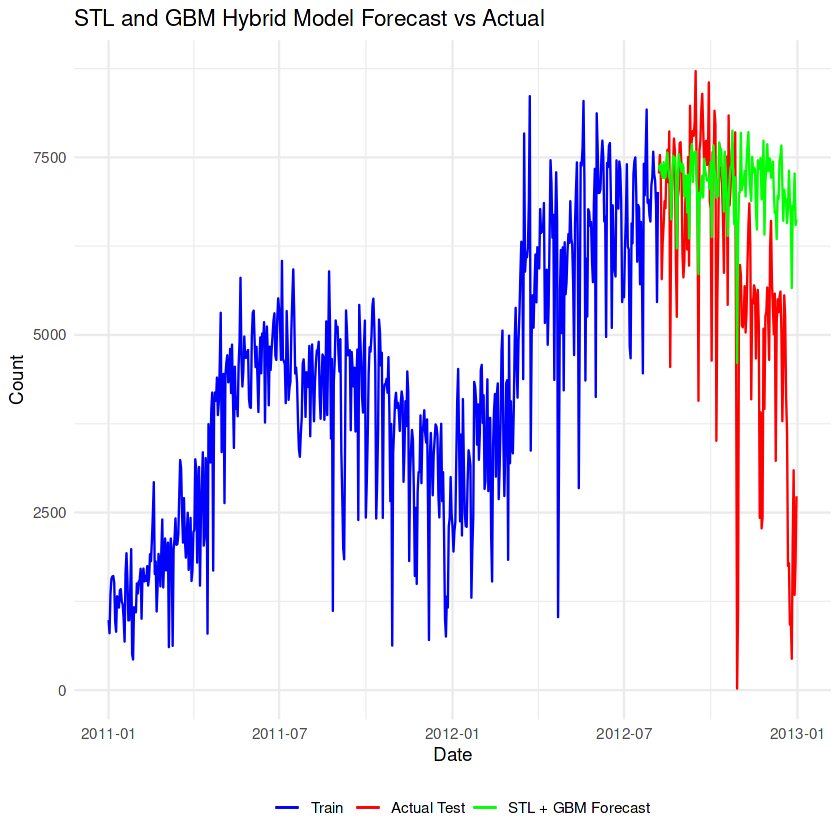

In [6]:
train_df <- data.frame(date = train_data$date, cnt = train_data$cnt, type = "Train")
test_df <- data.frame(date = test_data$date, cnt = test_data$cnt, type = "Test")
gbm_forecast_df <- data.frame(date = test_data$date, cnt = gbm_pred, type = "STL + GBM Forecast")

ggplot() +
  geom_line(data = train_df, aes(x = date, y = cnt, color = 'Train'), size = 0.5) +
  geom_line(data = test_df, aes(x = date, y = cnt, color = 'Actual Test'), size = 0.5) +
  geom_line(data = gbm_forecast_df, aes(x = date, y = cnt, color = 'STL + GBM Forecast'), size = 0.5) +
  labs(title = 'STL and GBM Hybrid Model Forecast vs Actual',
       x = 'Date',
       y = 'Count') +
  scale_color_manual(values = c('Train' = 'blue', 'Actual Test' = 'red', 'STL + GBM Forecast' = 'green'),
                     breaks = c('Train', 'Actual Test', 'STL + GBM Forecast')) +  
  theme_minimal() +
  theme(legend.position = "bottom") +
  guides(color = guide_legend(title = NULL))

The plot displaying the predictions of the STL and GBM hybrid model (green line) compared to the actual test data (red line) shows that the model performs well overall. The model closely follows the trend of the training data (blue line) and largely aligns with the test data during the forecast period.

Initially, the predictions align well with the actual values, indicating that the model captures the underlying patterns in the data effectively. However, it is observed that the model struggles to accurately forecast the sudden drops towards the end of the test period. Despite this, the STL + GBM hybrid model performs better than the previously evaluated SARIMAX models. This suggests that the hybrid model is more effective in capturing residual patterns and enhancing forecast accuracy.